# 2 Principal Component Analysis

Principal components are linear combinations of the original features, which are uncorrelated and ordered by the amount of variance they explain in the dataset. 
The first principal component accounts for the largest possible variance, while each subsequent component explains the maximum remaining variance orthogonal to the previous components.

The PCA algorithm involves the following steps:

- Standardize the data: Center the data by subtracting the mean and scaling the features to have unit variance, if necessary.
- Compute the covariance matrix of the standardized data.
- Calculate the eigenvalues and eigenvectors of the covariance matrix.
- Sort the eigenvalues and their corresponding eigenvectors in descending order.
- Select the first `k` eigenvectors, where `k` is the desired number of dimensions, to form a transformation matrix.
- Multiply the original data by the transformation matrix to obtain the new lower-dimensional data.

## 2.1 Mathematical Background



### 2.1.1 Notation
- mean: $\mu = \frac{1}{n} \sum_{i=1}^{n} x_i$
- variance: $\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)^2$
- covariance between X and Y: $cov(X,Y) = E[(X-E(X))(Y-E(Y))] = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu_x)(y_i - \mu_y)$

Convariance for 3-D data:

\begin{equation}
    COV(X,Y,Z) = 
    \begin{bmatrix}
        cov(X,X) & cov(X,Y) & cov(X,Z) \\
        cov(Y,X) & cov(Y,Y) & cov(Y,Z) \\
        cov(Z,X) & cov(Z,Y) & cov(Z,Z) \\    
    \end{bmatrix}
\end{equation}

### 2.1.2 Maximization of Variance


### 2.1.3 Minimization of Reconstruction Error
The PCA problem can also be formulated as an encoder-decoder strucuture, where the encoder is the PCA algorithm and the decoder is the reconstruction of the original data. 
The reconstruction error is the sum of squared differences between the original data and the reconstructed data. 
The goal is to minimize the reconstruction error by finding the principal components.


### 2.1.4 Eigendecomposition of the Covariance Matrix

**Questions**
- some said the eigendecomposition can be taken on the data matrix, instead of the covariance matrix, why?
- what are the differences of these two approaches?

The covariance matrix is a symmetric matrix, which means that it can be decomposed into a product of eigenvectors and eigenvalues.

Typical ways of computing the eigendecomposition of a matrix are:
- QR decomposition
- Singular value decomposition (SVD)
- Power iteration

Apparently, based on the discussion [here](https://stats.stackexchange.com/questions/314046/why-does-andrew-ng-prefer-to-use-svd-and-not-eig-of-covariance-matrix-to-do-pca), SVD is preferred over eigendecomposition because it is more numerically stable.




In [111]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp 
from jax import jit

class PCA():
    def __init__(self, k):
        self.k = k
        self.eigenvalues = None
        self.eigenvectors = None
    
    def fit(self, X):
        """Perform PCA on the data

        Args:
            X (jnp.array): input data, shape (n_samples, n_features)
        """
        # assume data is standardized
        # SVD decomposition on data
        # using SVD leads to diffrent figures at the end (mirrored versions). 
        # scikit learn uses SVD as well, but X = (-U) @ S @ (-V.T)
        u, s, _ = jnp.linalg.svd(X.T)
        self.eigenvectors = -u
        self.eigenvalues = s**2
        
        # use eigenvalue decomposition
        #s, u = jnp.linalg.eig(jnp.cov(X.T))
        #self.eigenvectors = u 
        #self.eigenvalues = s
        
        # the first k components
        # the eigenvalues are already sorted in descending order
        transform_matrix = self.eigenvectors[:, :self.k]
        
        # project the data onto the k components
        X_transformed = X @ transform_matrix
        
        return X_transformed
    
        

In [112]:
# get some data
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()


,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [113]:
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
X.shape

(150, 4)

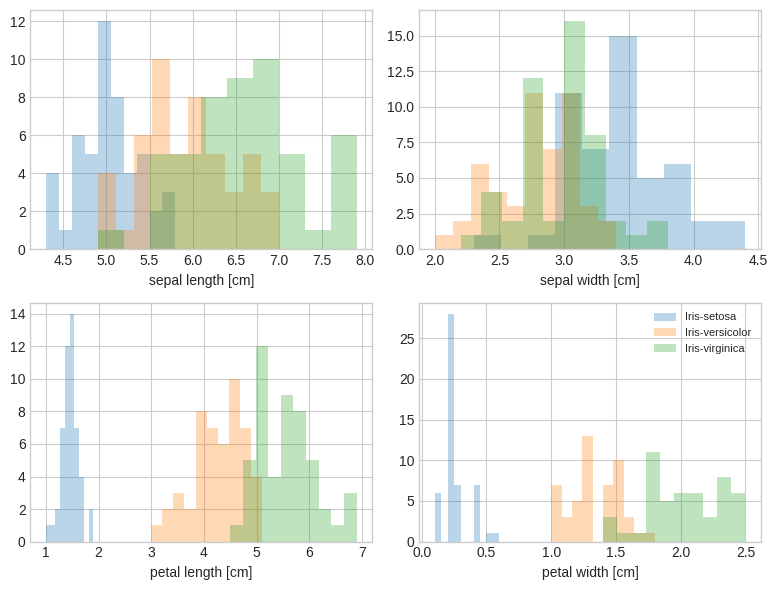

In [114]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()


In [115]:
# standardize the data
def standardize_data(X):
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std

X_std = standardize_data(X)
X_std.shape


(150, 4)

In [116]:
# compare eigendecomposition method: QR decomposition on covariance matrix
eig_vals, eig_vecs = jnp.linalg.eig(jnp.cov(X_std.T))
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.5223718 +0.j -0.37231818+0.j -0.72101706+0.j  0.26199543+0.j]
 [-0.2633547 +0.j -0.92555654+0.j  0.24203244+0.j -0.1241348 +0.j]
 [ 0.5812539 +0.j -0.02109469+0.j  0.14089267+0.j -0.80115426+0.j]
 [ 0.5656112 +0.j -0.06541599+0.j  0.63380116+0.j  0.5235464 +0.j]]

Eigenvalues 
[2.930354  +0.j 0.9274032 +0.j 0.14834207+0.j 0.02074597+0.j]


In [117]:
# QR decomposition for eigenvalues on data matrix
eig_vals, eig_vecs = jnp.linalg.eig(X_std.T @ X_std)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.5223715 +0.j -0.37231833+0.j -0.721017  +0.j  0.2619952 +0.j]
 [-0.26335505+0.j -0.9255565 +0.j  0.24203286+0.j -0.12413497+0.j]
 [ 0.58125395+0.j -0.02109477+0.j  0.14089262+0.j -0.80115414+0.j]
 [ 0.56561124+0.j -0.06541583+0.j  0.6338011 +0.j  0.5235465 +0.j]]

Eigenvalues 
[436.6228  +0.j 138.18323 +0.j  22.10297 +0.j   3.091142+0.j]


In [118]:
# Compare eigendecomposition method: SVD
# u is eigenvectors for X_std.T @ X_std
# s is singular values as the square root of the eigenvalues of X_std.T @ X_std or X_std @ X_std.T
u,s,v = jnp.linalg.svd(X_std.T)
print(u)
print(s)

[[-0.5223717  -0.37231833  0.7210167   0.26199567]
 [ 0.26335496 -0.9255563  -0.24203277 -0.12413488]
 [-0.5812541  -0.02109483 -0.1408923  -0.80115426]
 [-0.56561095 -0.06541584 -0.63380134  0.5235464 ]]
[20.895517  11.755135   4.7013803  1.7581688]


Basically, we can see with standardization, the eigenvectors are the same for both the covariance matrix and the data matrix if the data is standardized.


In [119]:
# perform PCA
pca = PCA(k=2)
X_std_transformed = jit(pca.fit)(X_std)
print(pca.eigenvectors)
print(pca.eigenvalues)
print(X_std_transformed.shape)

Traced<ShapedArray(float32[4,4])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
(150, 2)


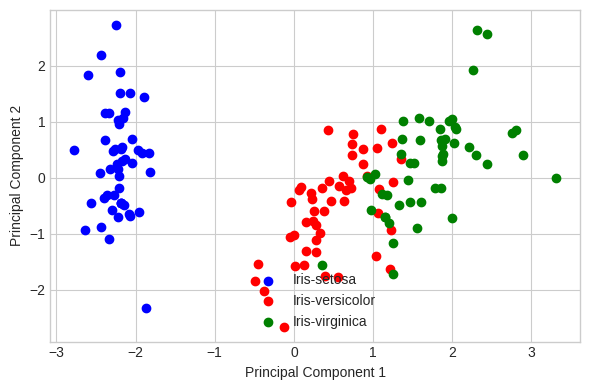

In [120]:
# plot new feature space
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(X_std_transformed[y==lab, 0],
                    X_std_transformed[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()